In [29]:
import os
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyro
import seaborn as sns
import torch
from math import ceil, floor
import functools
import dill
import sys

import bayes_air.utils.dataloader as ba_dataloader
from bayes_air.model import augmented_air_traffic_network_model_simplified
from bayes_air.network import NetworkState, AugmentedNetworkState
from bayes_air.schedule import split_and_parse_full_schedule

from scripts.lga.lga_network import *

from tqdm.notebook import tqdm


In [34]:
rng_seed = 1

pyro.clear_param_store()  # avoid leaking parameters across runs
pyro.enable_validation(True)
pyro.set_rng_seed(int(rng_seed))

day_strs_list = [['2019-07-04'], ['2019-07-10']]
network_airport_codes = ['LGA']
dt = .1

device = torch.device("cpu")

# Hyperparameters
initial_aircraft = 50.0 # not used!
mst_effective_hrs = 24 # not used!
mst_split = 1 # not really used

subsamples = {}

for day_strs in day_strs_list:
    # gather data
    days = pd.to_datetime(day_strs)
    data = ba_dataloader.load_remapped_data_bts(days)
    name = day_strs[0]

    num_days = len(days)
    num_flights = sum([len(df) for df in data.values()])

    # make things with the data
    travel_times_dict, observations_df = \
        make_travel_times_dict_and_observation_df(
            data, network_airport_codes
        ) 
    states = make_states(data, network_airport_codes)

    model = functools.partial(
        augmented_air_traffic_network_model_simplified,

        travel_times_dict=travel_times_dict,
        initial_aircraft=initial_aircraft,

        include_cancellations=False,
        mean_service_time_effective_hrs=mst_effective_hrs,
        delta_t=dt,

        source_use_actual_departure_time=True,
        source_use_actual_cancelled=False,
    )

    subsamples[name] = {
        "model": model,
        "states": states,
        "travel_times_dict": travel_times_dict,
        "observations_df": observations_df,
    }

print(subsamples.keys())

dict_keys(['2019-07-04', '2019-07-10'])


In [39]:
def get_samples_df(name, mst, n):
    sdd = pd.DataFrame()
    for i in tqdm(range(n)):
        posterior_samples = {
            'LGA_0_mean_service_time': torch.tensor([mst]).to(device)
        }
        s = subsamples[name]
        model, states, observations_df = s["model"], s["states"], s["observations_df"]
        hourly_delays = get_hourly_delays_from_z_sample(model, posterior_samples, states, observations_df)
        sdd[i] = hourly_delays.sample_departure_delay
    return sdd


In [46]:
sdd_a = get_samples_df('2019-07-04', .020, 20)
display(sdd_a)

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,0.006325,0.010641,0.003124,0.036383,0.024873,0.036443,0.031948,0.054945,0.019177,0.026621,0.017447,0.003452,0.019257,0.022770,0.025277,-0.008003,0.020645,0.036080,-0.001499,-0.011261
6,0.076084,0.089753,0.042164,0.105662,0.071648,0.103282,0.063574,0.060926,0.050940,0.096238,0.085778,0.051912,0.103220,0.048530,0.124952,0.110311,0.074871,0.091198,0.056407,0.083135
7,0.068671,0.063900,0.132868,0.094017,0.079727,0.055100,0.057047,0.073310,0.053154,0.091799,0.065214,0.084842,0.126574,0.084896,0.077727,0.060146,0.075438,0.067925,0.063226,0.072119
8,0.125792,0.214421,0.265712,0.160694,0.140208,0.091137,0.343338,0.156610,0.164899,0.260381,0.210458,0.301901,0.239618,0.139168,0.322430,0.259342,0.124075,0.124284,0.345319,0.111825
9,0.293384,0.348411,0.330982,0.242183,0.303401,0.226020,0.475849,0.236563,0.346453,0.246151,0.287324,0.504283,0.225373,0.451000,0.511206,0.328171,0.245132,0.336887,0.612780,0.282238
10,0.632637,0.407358,0.533051,0.402030,0.427447,0.451000,0.858191,0.603793,0.508106,0.482544,0.431447,0.546587,0.300400,0.607825,0.720620,0.576216,0.565869,0.481422,0.836062,0.537449
11,0.661482,0.419468,0.657658,0.405588,0.413120,0.641293,0.978172,0.628678,0.550181,0.511277,0.534226,0.726137,0.241278,0.572642,0.824004,0.712868,0.693274,0.488131,0.908946,0.451250
12,0.559209,0.442727,0.658500,0.375882,0.446825,0.574491,1.129455,0.508937,0.567413,0.678393,0.537170,0.765203,0.268194,0.582834,0.883252,0.818495,0.961477,0.506685,0.930325,0.446960
13,0.490440,0.405198,0.565308,0.384116,0.554110,0.345949,1.169416,0.449506,0.472357,0.544013,0.495212,0.655914,0.298417,0.582262,0.674172,0.791541,1.061656,0.582829,0.960033,0.502459
14,0.410180,0.397187,0.226531,0.416482,0.500896,0.204136,1.239687,0.256909,0.403273,0.544468,0.396932,0.347599,0.275660,0.291974,0.371412,0.605951,0.761568,0.480335,0.762018,0.262992


<Axes: >

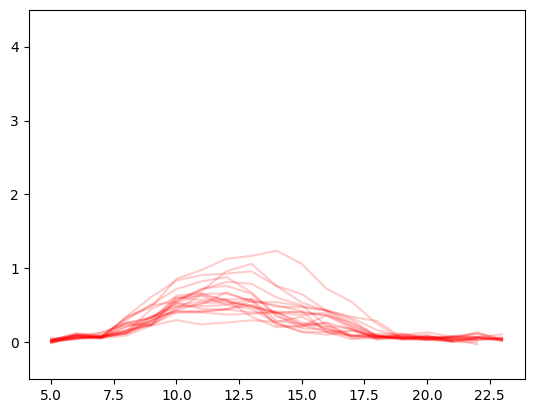

In [47]:
sdd_a.plot(legend=False, style='-r', alpha=.2, ylim=(-.5,4.5))

In [48]:
sdd_b = get_samples_df('2019-07-10', .020, 20)
display(sdd_b)

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
5,-0.021071,-0.007890,0.027164,0.013826,0.011263,0.055964,0.020557,0.023423,0.052773,0.003514,0.006477,0.040003,0.020443,0.049502,-0.000699,-0.010571,0.006921,0.046533,0.004682,0.024999
6,0.091142,0.160326,0.145316,0.227928,0.161637,0.168500,0.131526,0.137305,0.193514,0.107963,0.154714,0.134744,0.169119,0.223570,0.107260,0.229429,0.170120,0.170821,0.145896,0.167801
7,0.092256,0.106783,0.113717,0.106757,0.096468,0.128823,0.106068,0.114134,0.241460,0.076942,0.119290,0.166811,0.152795,0.113758,0.088731,0.150665,0.094092,0.123448,0.169454,0.099913
8,0.331554,0.443163,0.387146,0.372084,0.320399,0.593985,0.374661,0.370717,0.509982,0.374339,0.619549,0.418949,0.483504,0.489837,0.396692,0.445216,0.326329,0.283968,0.528883,0.480450
9,0.797459,0.874048,0.750264,0.772009,0.678080,1.126154,0.749348,0.707917,0.948819,0.636338,0.983364,0.796403,0.824079,0.998102,0.727447,0.837629,0.785280,0.782710,0.862324,0.758463
10,1.203637,1.213320,1.096822,1.036982,1.027662,1.214383,1.173220,1.068208,1.300696,1.023701,1.309941,1.198696,1.120295,1.218217,0.996279,1.280465,1.078036,1.175025,1.269576,1.319163
11,1.365902,1.457798,1.427890,1.382947,1.372363,1.675889,1.540892,1.403207,1.636025,1.322821,1.479288,1.599166,1.312580,1.503457,1.356582,1.713617,1.393293,1.501466,1.398813,1.832204
12,1.676906,1.564447,1.649379,1.535011,1.553302,1.823707,1.746478,1.576141,1.757444,1.573276,1.654896,1.792977,1.436791,1.871488,1.860605,1.929616,1.554917,1.757542,1.534166,2.216019
13,2.071539,1.748103,1.980013,1.705876,1.663678,2.196651,2.122838,1.794677,2.036594,2.076649,1.784857,1.837120,1.472280,2.073241,2.054676,1.978702,1.722151,2.085318,1.788971,2.213598
14,2.156481,1.925809,2.114264,1.847778,1.893117,2.161141,2.101134,1.815053,2.258416,2.252453,1.996944,1.926777,1.587737,2.192271,2.163813,2.203124,1.878085,2.251471,1.948900,2.552171


<Axes: >

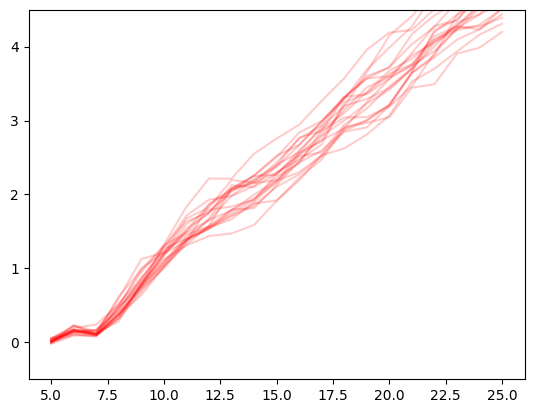

In [49]:
sdd_b.plot(legend=False, style='-r', alpha=.2, ylim=(-.5,4.5))